In [1]:
import pandas as pd
import numpy as np

In [17]:
def get_returns_df(df, N=1, log=False):
    if log:
        return np.log(df / df.shift(N)).iloc[N-1:].fillna(0)
    else:
        return df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)

def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()    # same with (return_df.cumsum() + 1)

def get_CAGR_series(cum_rtn_df, num_day_in_year=250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df))) - 1
    return cagr_series

def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 - yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

def get_drawdown_infos(cum_returns_df):
    # 1. Drawdown
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df - 1

    # 2. Maximum drawdown
    mdd_series = dd_df.min()

    # 3. longest_dd_period
    dd_duration_info_list = list()
    max_point_df = dd_df[dd_df == 0]
    for col in max_point_df:
        _df = max_point_df[col]
        _df.loc[dd_df[col].last_valid_index()] = 0
        _df = _df.dropna()

        periods = _df.index[1:] - _df.index[:-1]

        days = periods.days
        max_idx = days.argmax()

        longest_dd_period = days.max()
        dd_mean = int(np.mean(days))
        dd_std = int(np.std(days))

        dd_duration_info_list.append(
            [
                dd_mean,
                dd_std,
                longest_dd_period,
                "{} ~ {}".format(_df.index[:-1][max_idx].date(), _df.index[1:][max_idx].date())
            ]
        )

    dd_duration_info_df = pd.DataFrame(
        dd_duration_info_list,
        index=dd_df.columns,
        columns=['drawdown mean', 'drawdown std', 'longest days', 'longest period']
    )
    return dd_df, mdd_series, dd_duration_info_df

In [18]:
from functools import reduce

def calculate_portvals(price_df, weight_df):
    cum_rtn_up_until_now = 1
    individual_port_val_df_list = []

    prev_end_day = weight_df.index[0]
    for end_day in weight_df.index[1:]:
        sub_price_df = price_df.loc[prev_end_day:end_day]
        sub_asset_flow_df = sub_price_df / sub_price_df.iloc[0]

        weight_series = weight_df.loc[prev_end_day]
        indi_port_cum_rtn_series = (sub_asset_flow_df * weight_series) * cum_rtn_up_until_now

        individual_port_val_df_list.append(indi_port_cum_rtn_series)

        total_port_cum_rtn_series = indi_port_cum_rtn_series.sum(axis=1)
        cum_rtn_up_until_now = total_port_cum_rtn_series.iloc[-1]

        prev_end_day = end_day

    individual_port_val_df = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
    return individual_port_val_df

def get_rebal_dates(price_df, period="month"):
    _price_df = price_df.reset_index()
    if period == "month":
         groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month]
    elif period == "quarter":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.quarter]
    elif period == "halfyear":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month // 7]
    elif period == "year":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.year]
    rebal_dates = pd.to_datetime(_price_df.groupby(groupby)['date_time'].last().values)
    return rebal_dates

In [19]:
result_portval_dict = {}

In [20]:
# Buy and Hold
all_ticker_price_df = pd.read_csv("../data/sample/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[['QQQ', 'IEF']].dropna()

individual_port_val_df = price_df / price_df.iloc[0] * [0.5, 0.5]
result_portval_dict['buy_and_hold'] = individual_port_val_df.sum(axis=1)

In [21]:
all_ticker_price_df.columns

Index(['AGG', 'BND', 'EEM', 'EWJ', 'GLD', 'GSG', 'HYG', 'IEF', 'IEI', 'IJS',
       'IWM', 'LQD', 'QQQ', 'SHV', 'SHY', 'SPY', 'TLT', 'UST', 'VEA', 'VGK',
       'VNQ', 'VTI', 'VWO'],
      dtype='object')

In [22]:
## Basic DAA
offense_assets = ["SPY", "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "HYG", "LQD"]
defense_assets = ["SHV", "IEF", "TLT"]  # UST대신 TLT로 대체
canary_assets = ["VWO", "BND"]   # VWO는 offense_asset에도 존재

all_ticker_price_df = pd.read_csv("../data/sample/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[
    list(set(offense_assets + defense_assets + canary_assets))
]

price_df = price_df.dropna()
rebal_dates = get_rebal_dates(price_df)

In [23]:
momentum_df = price_df.loc[rebal_dates].copy()

momentum_result_df = (12 * momentum_df.pct_change(1)) + (4 * momentum_df.pct_change(3)) \
                                                      + (2 * momentum_df.pct_change(6)) \
                                                      + (1 * momentum_df.pct_change(12))

momentum_result_df = momentum_result_df.dropna()
momentum_result_df

,VWO,IEF,HYG,BND,GLD,QQQ,SPY,EWJ,TLT,VNQ,GSG,LQD,VGK,SHV,IWM
2008-04-30,1.350417,0.040748,0.632969,0.121775,-0.211115,0.894807,0.374719,0.867316,-0.029516,0.893668,2.758146,0.239477,0.487259,0.162377,0.214990
2008-05-30,0.648723,-0.167605,0.140711,-0.061950,0.344049,1.383813,0.238172,0.439058,-0.363770,0.429543,3.042473,-0.310653,0.185361,0.106475,0.749165
2008-06-30,-1.355950,0.223744,-0.508006,0.035794,1.224782,-1.299930,-1.468406,-1.086232,0.403732,-1.673640,4.021319,-0.243184,-1.622896,0.119165,-1.198135
2008-07-31,-1.226898,0.214360,-0.036368,0.013695,0.325355,-0.091554,-0.667273,-1.080637,0.018918,0.040905,-0.517867,-0.103755,-1.028524,0.113311,0.408120
2008-08-29,-2.216924,0.443499,-0.270983,0.193102,-1.450101,-0.036928,-0.291412,-1.550056,0.688188,0.123231,-0.908890,-0.046081,-1.406909,0.096465,0.506679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,1.253009,-0.178005,0.414948,-0.006923,0.190112,2.083332,2.195011,0.475416,-0.423595,2.633588,3.339297,0.044281,2.197807,-0.000976,2.298582
2021-05-28,1.070730,-0.134657,0.254087,-0.050321,1.566499,0.789057,1.250743,0.618490,-0.513768,1.442413,1.857205,0.029815,1.943056,-0.000299,1.319329
2021-06-30,0.938576,0.108736,0.421208,0.143283,-0.869075,1.903552,1.317202,0.134907,0.547046,1.553166,2.257505,0.410956,0.802163,-0.003963,1.349405
2021-07-30,-0.622043,0.335955,0.209890,0.225449,0.287505,1.365940,1.258408,0.202150,0.648156,1.741399,1.515953,0.379690,1.108671,-0.001611,0.175916


In [24]:
# 카나리 신호 계산
canary_signal_series = (momentum_result_df[canary_assets] > 0).sum(axis=1)

momentum_result_df['canary_signal'] = canary_signal_series

In [25]:
def set_weight(series):
    canary_score = series.loc["canary_signal"]
    if canary_score == 0:
        target_assets = series.loc[defense_assets].sort_values().iloc[-1:].index
        return pd.Series([1], index=target_assets)
    elif canary_score == 1:
        target_assets1 = series.loc[offense_assets].sort_values().iloc[-2:].index
        target_assets2 = series.loc[defense_assets].sort_values().iloc[-1:].index
        return pd.Series(
            [0.25, 0.25, 0.5],
            index=target_assets1.tolist() + target_assets2.tolist()
        )
    else:
        target_assets = series.loc[offense_assets].sort_values().iloc[-2:].index
        return pd.Series([0.5, 0.5], index=target_assets)

target_weight_df = momentum_result_df.apply(set_weight, axis=1).fillna(0)

,Sharpe Ratio
portval,0.727753


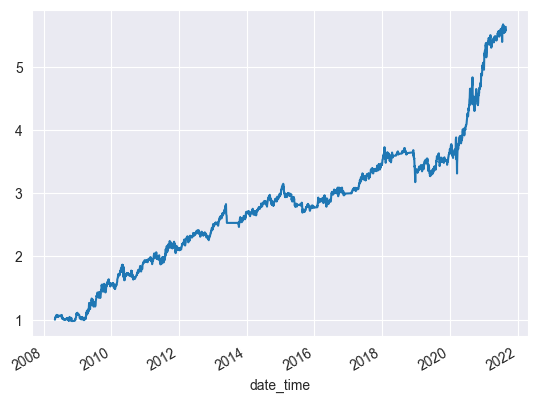

In [26]:
# DAA 포트폴리오 평가
individual_port_val_df = calculate_portvals(price_df, target_weight_df)

result_portval_dict['daa'] = individual_port_val_df.sum(axis=1)
result_portval_dict['daa'].plot()

portval_df = result_portval_dict['daa'].to_frame("portval")
get_sharpe_ratio(get_returns_df(portval_df, log=True)).to_frame("Sharpe Ratio")

In [27]:
get_CAGR_series(portval_df).to_frame("CAGR")

,CAGR
portval,0.137425


<Axes: xlabel='date_time'>

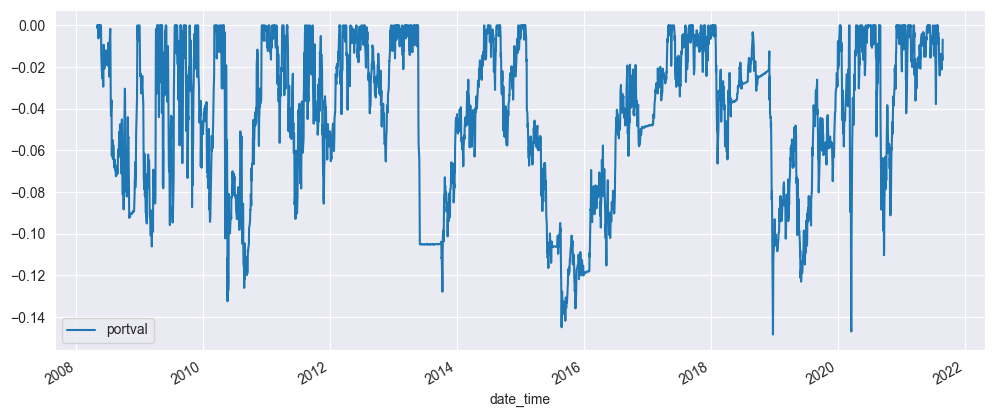

In [28]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(portval_df)
dd_df.plot(figsize=(12, 5))

In [66]:
## GPT DAA
offense_assets = ["SPY", "VTI", "QQQ", "IWM", "IJS", "VEA", "VGK", "EWJ", "EEM", "VWO", "VNQ", "HYG", "GSG"]
defense_assets = ["AGG", "BND", "IEF", "IEI", "SHY", "SHV", "LQD", "TLT", "UST", "GLD"]  # UST대신 TLT로 대체
canary_assets = ["VWO", "BND"]   # VWO는 offense_asset에도 존재

all_ticker_price_df = pd.read_csv("../data/sample/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[
    list(set(offense_assets + defense_assets + canary_assets))
]

price_df = price_df.dropna()
rebal_dates = get_rebal_dates(price_df)

In [67]:
momentum_df = price_df.loc[rebal_dates].copy()

momentum_result_df = (12 * momentum_df.pct_change(1)) + (4 * momentum_df.pct_change(3)) \
                                                      + (2 * momentum_df.pct_change(6)) \
                                                      + (1 * momentum_df.pct_change(12))

momentum_result_df = momentum_result_df.dropna()
momentum_result_df

,VTI,UST,VGK,IWM,VWO,IEI,SPY,TLT,LQD,SHY,...,EWJ,VNQ,IJS,HYG,BND,QQQ,GLD,EEM,SHV,GSG
2011-01-31,1.257544,-0.192448,1.112024,1.139007,0.119047,0.029059,1.226960,-0.818781,0.005001,0.028960,...,0.827143,1.320402,1.071928,0.639540,0.003981,1.417047,-0.373838,-0.008269,0.000670,1.522538
2011-02-28,1.807770,-0.584378,1.770070,2.289280,0.653156,-0.118613,1.716995,-0.220619,0.208641,-0.008036,...,1.831833,1.905074,1.986139,0.774850,0.042011,1.797833,1.299177,0.617453,0.004059,1.699042
2011-03-31,0.853353,-0.063682,0.473629,1.382282,1.095728,-0.037047,0.739001,-0.200413,-0.009769,-0.011244,...,-1.371932,0.590414,1.188006,0.393573,0.022060,0.722942,0.695207,1.206566,0.004398,1.488007
2011-04-29,1.168402,0.454466,1.999385,1.453652,1.178796,0.250481,1.102972,0.414014,0.515423,0.093236,...,0.241765,1.581757,0.972503,0.569324,0.294801,1.054281,2.385025,1.087159,0.013431,1.674473
2011-05-31,0.547819,1.096289,0.657086,0.562662,0.381605,0.389815,0.492451,0.699148,0.462307,0.102824,...,-0.624563,1.081317,0.371492,0.427857,0.335960,0.441247,0.601863,0.365116,0.004559,-0.176231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,2.227890,-0.338580,2.197807,2.298582,1.253009,-0.044057,2.195011,-0.423595,0.044281,0.005093,...,0.475416,2.633588,3.021447,0.414948,-0.006923,2.083332,0.190112,1.131012,-0.000976,3.339297
2021-05-28,1.224626,-0.306836,1.943056,1.319329,1.070730,0.000300,1.250743,-0.513768,0.029815,0.012389,...,0.618490,1.442413,2.597237,0.254087,-0.050321,0.789057,1.566499,1.035844,-0.000299,1.857205
2021-06-30,1.371782,0.185897,0.802163,1.349405,0.938576,-0.036224,1.317202,0.547046,0.410956,-0.026249,...,0.134907,1.553166,1.484378,0.421208,0.143283,1.903552,-0.869075,0.811391,-0.003963,2.257505
2021-07-30,1.139635,0.720045,1.108671,0.175916,-0.622043,0.149938,1.258408,0.648156,0.379690,0.021079,...,0.202150,1.741399,0.416959,0.209890,0.225449,1.365940,0.287505,-0.778177,-0.001611,1.515953


In [68]:
# 카나리 신호 계산
canary_signal_series = (momentum_result_df[canary_assets] > 0).sum(axis=1)

momentum_result_df['canary_signal'] = canary_signal_series

In [69]:
momentum_result_df.columns

Index(['VTI', 'UST', 'VGK', 'IWM', 'VWO', 'IEI', 'SPY', 'TLT', 'LQD', 'SHY',
       'IEF', 'AGG', 'VEA', 'EWJ', 'VNQ', 'IJS', 'HYG', 'BND', 'QQQ', 'GLD',
       'EEM', 'SHV', 'GSG', 'canary_signal'],
      dtype='object')

In [70]:
target_weight_df = momentum_result_df.apply(set_weight, axis=1).fillna(0)

,Sharpe Ratio
portval,0.484304


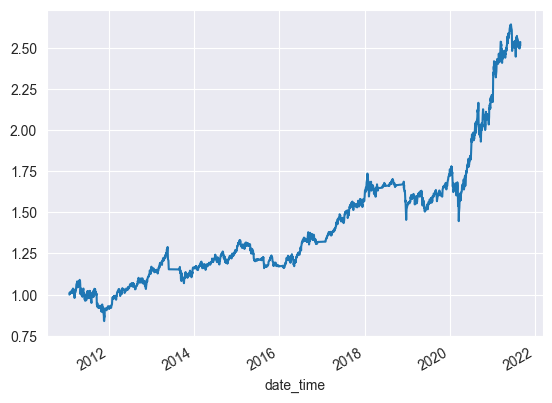

In [71]:
# DAA 포트폴리오 평가
individual_port_val_df = calculate_portvals(price_df, target_weight_df)

result_portval_dict['daa_gpt'] = individual_port_val_df.sum(axis=1)
result_portval_dict['daa_gpt'].plot()

portval_df = result_portval_dict['daa_gpt'].to_frame("portval")
get_sharpe_ratio(get_returns_df(portval_df, log=True)).to_frame("Sharpe Ratio")

In [72]:
get_CAGR_series(portval_df).to_frame("CAGR")

,CAGR
portval,0.091207


<Axes: xlabel='date_time'>

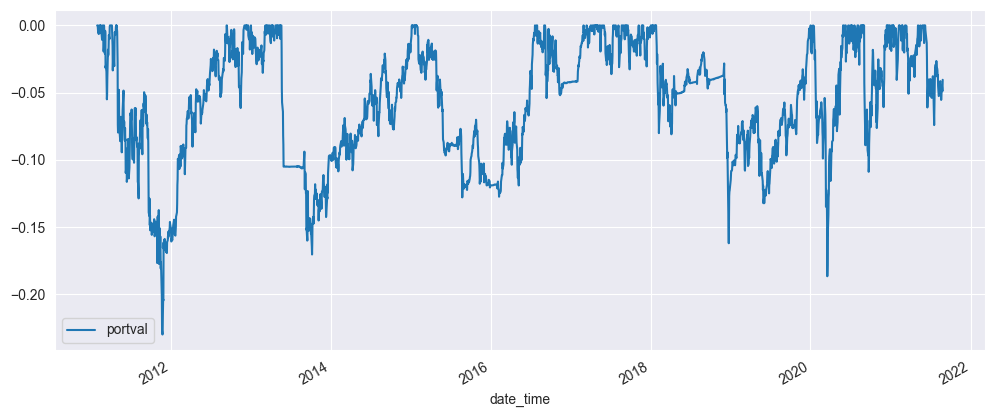

In [73]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(portval_df)
dd_df.plot(figsize=(12, 5))

<Axes: xlabel='date_time'>

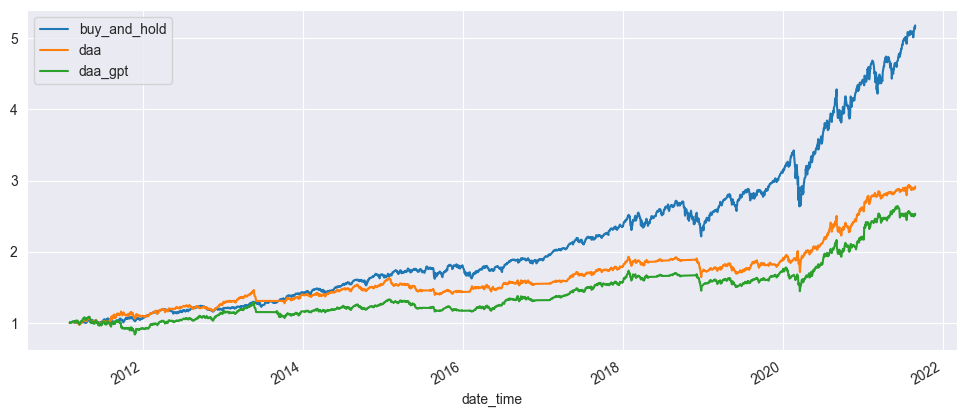

In [74]:
# 포트폴리오 종합 비교
compare_df = pd.DataFrame(result_portval_dict).dropna()
compare_df = compare_df / compare_df.iloc[0]
compare_df.plot(figsize=(12, 5))

In [75]:
get_sharpe_ratio(get_returns_df(compare_df, log=True)).sort_values(ascending=False).to_frame("Sharpe Ratio")

,Sharpe Ratio
buy_and_hold,0.906344
daa,0.642092
daa_gpt,0.484304


In [76]:
get_CAGR_series(compare_df).sort_values(ascending=False).to_frame("CAGR")

,CAGR
buy_and_hold,0.166894
daa,0.105720
daa_gpt,0.091207


<Axes: xlabel='date_time'>

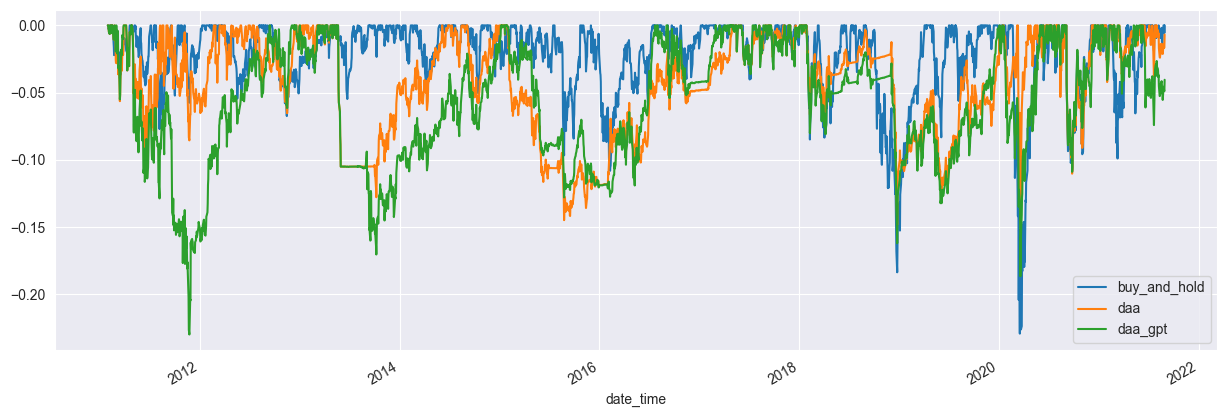

In [77]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df)
dd_df.plot(figsize=(15, 5))

In [78]:
mdd_series.sort_values().to_frame("MDD")

,MDD
daa_gpt,-0.230032
buy_and_hold,-0.229369
daa,-0.148401


In [79]:
longest_dd_period_df

,drawdown mean,drawdown std,longest days,longest period
buy_and_hold,8,22,226,2015-12-01 ~ 2016-07-14
daa,16,76,823,2015-01-29 ~ 2017-05-01
daa_gpt,20,86,706,2018-01-26 ~ 2020-01-02


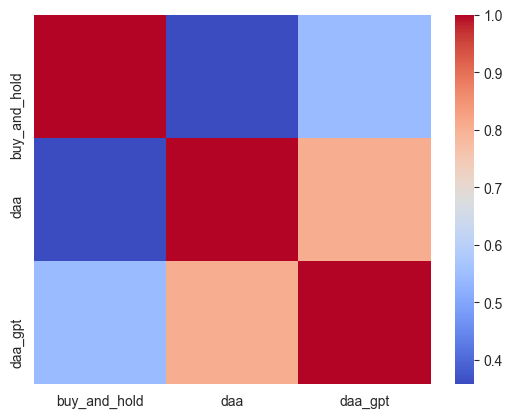

In [80]:
import seaborn as sns

# 포트폴리오 상관관계 히트맵
sns.heatmap(compare_df.pct_change().corr(), cmap="coolwarm");